# 1. Setup

In [ ]:
# add root path to system path
import sys
import os

sys.path.append('../')

os.chdir("../")

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from utility.utils import export_submission, WordEmbeddingVectorizer, load_preprocessed_data, \
    load_preprocessed_full_data, load_preprocessed_test_data
from utility.paths import DataPath

import gensim

This notebook is similar to the one about [Stochastic Gradient Descent (SGD)](./model_SGD.ipynb). Therefore, we won't go over the concepts again, but will instead focus on the results and discuss them.

# 2. Data loading

First, we will load the pre-processed datasets.

In [3]:
# Load the data
data_train = load_preprocessed_data()

In [4]:
# Split the data into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(data_train["text"], data_train['label'], test_size=0.2,
                                                                random_state=42)

# 3. Text Vectorizer

Now, we will conduct a grid search to identify the optimal text vectorizer for **Logistic Regression** the followings :

- `Count Vectorizer`
- `TF-IDF Vectorizer`
- `Word2Vec`

This will include determining their best hyperparameters.

#### Count Vectorizer

In [8]:
# Define pipeline for Count Vectorizer
pipeline_count = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Parameter grid for Count Vectorizer pipeline
parameter_grid_count = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
}

# Grid search for Count Vectorizer pipeline
grid_search_count = GridSearchCV(pipeline_count, parameter_grid_count, cv=5)

# Fit the grid search to the data
grid_search_count.fit(X_train, y_train)

# After fitting, we can access the best parameters, best score, etc.
print("Count Vectorizer - Best parameters:", grid_search_count.best_params_)
print("Count Vectorizer - Best score:", grid_search_count.best_score_)

Count Vectorizer - Best parameters: {'vect__ngram_range': (1, 3)}
Count Vectorizer - Best score: 0.8155027999920159


#### TF-IDF Vectorizer

In [9]:
# Define pipeline for TF-IDF
pipeline_tfidf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Parameter grid for TF-IDF pipeline
parameter_grid_tfidf = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
}

# Grid search for TF-IDF pipeline
grid_search_tfidf = GridSearchCV(pipeline_tfidf, parameter_grid_tfidf, cv=5)

# Fit the grid search to the data
grid_search_tfidf.fit(X_train, y_train)

# After fitting, you can access the best parameters, best score, etc.
print("TF-IDF - Best parameters:", grid_search_tfidf.best_params_)
print("TF-IDF - Best score:", grid_search_tfidf.best_score_)

TF-IDF - Best parameters: {'vect__ngram_range': (1, 2)}
TF-IDF - Best score: 0.8068081700760263


#### Word2Vec

In [10]:
# Load Google's pre-trained Word2Vec model.
model_path = 'GoogleNews-vectors-negative300.bin'
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [11]:
# Create an instance of the WordEmbeddingVectorizer with our Word2Vec model
word_vectorizer = WordEmbeddingVectorizer(word_vectors)

# Create a pipeline
pipeline = Pipeline([
    ('word2vec', word_vectorizer),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Calculate and print the accuracy
accuracy = pipeline.score(X_validation, y_validation)
print("Accuracy:", accuracy)

Accuracy: 0.6272822549506316


# 4. Optimization of the Logistic Regression model

As with the SGD model, the vectorizer that yields the best accuracy is `CountVectorizer` with the parameters `ngram_range=(1, 3)`. Now let's use it to find the best Logistic Regression hyperparameters with a grid search.

### Definition of the model

First, let's vectorize the data with the best vectorizer

In [12]:
# CountVectorizer
best_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_train_vectorized = best_vectorizer.fit_transform(X_train)
X_validation_vectorized = best_vectorizer.transform(X_validation)

Now let's train the Logisitic Regression model with the vectorized data

In [21]:
# Instanciate an Logistic Regression classifier
clf = LogisticRegression(max_iter=1000)
start_time = time.time()
clf.fit(X_train_vectorized, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

# Get decision scores instead of binary predictions
y_train_scores = clf.predict_proba(X_train_vectorized)
y_validation_scores = clf.predict_proba(X_validation_vectorized)
print(f"Training time: {elapsed_time:.2f} sec")

Training time: 141.27 sec


### Grid search for optimal decision boundary threshold

Now let's find the best decision boundary threshold for the positive and negative labels. This time, the threshold is bounded to a range between 0 and 1 because the Logistic regression outputs the probability of a sample belonging to a specific class.

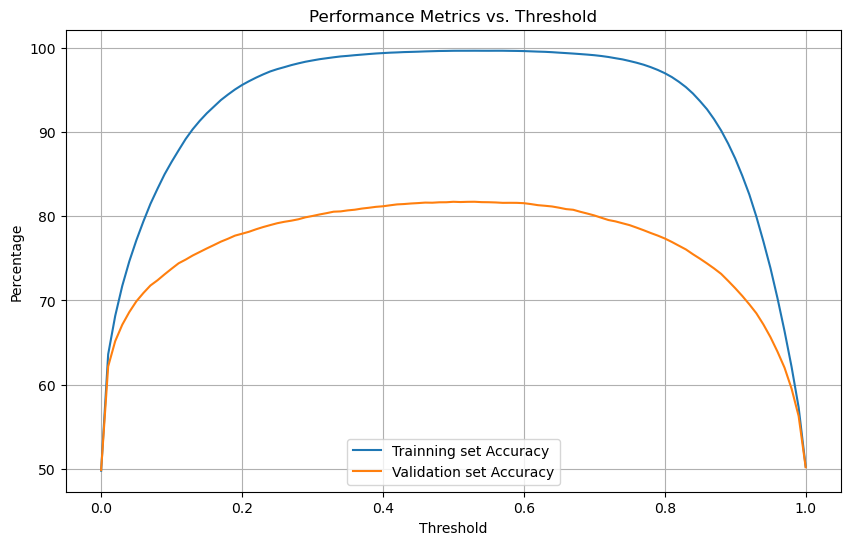

In [26]:
# Define the thresholds to test
thresholds = np.arange(0, 1.01, 0.01)

# Initialize empty lists to store accuracy and F1 scores
train_accuracies = []
validation_accuracies = []

# Loop through each threshold
for threshold in thresholds:
    y_train_pred = np.where(y_train_scores[:, 1] >= threshold, 1, -1)
    y_validation_pred = np.where(y_validation_scores[:, 1] >= threshold, 1, -1)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    validation_accuracy = accuracy_score(y_validation, y_validation_pred)

    train_accuracies.append(train_accuracy * 100)
    validation_accuracies.append(validation_accuracy * 100)

# Create a line plot for training set
plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_accuracies, label='Trainning set Accuracy')

# Create a line plot for validation set
plt.plot(thresholds, validation_accuracies, label='Validation set Accuracy')

plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Performance Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Find the index of the max validation accuracy
max_accuracy_index = np.argmax(validation_accuracies)

# Get the corresponding threshold
optimal_threshold = thresholds[max_accuracy_index]

print(
    f"The threshold for maximum validation accuracy {validation_accuracies[max_accuracy_index]:.2f}% is: {optimal_threshold:.2f}")

The threshold for maximum validation accuracy 81.73% is: 0.53


Since the best threshold that we found is 0.53 (	$\approx$ 0.5), this is statistically coherent with the fact that the training data are balanced 50.2% negative and 49.8% positive. Therefore, we can keep the regular decision boundary of the Logistic Regression model which is 0.5.

### Grid search for optimal learning rate

Logistic Regression involves two interconnected learning hyperparameters: `gamma` and `max_iter`. We will conduct a grid search to determine the best values for these parameters.

In [29]:
# Define Logistic Regression classifier
clf = LogisticRegression()

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'max_iter': [500, 1000, 5000]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_vectorized, y_train)

# After fitting, access the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 1, 'max_iter': 500}
Best score: 0.8155096953548681


### Grid search for optimal regularization

A grid search was initially planned on three parameters :

- `penalty`
- `ratio`
- `solver`

However, it was discovered that the Logisitc Regression model does not support the combination of these parameters. Additionally, addressing solver incompatibilities led to issues with the gradient descent not converging. Given these challenges, the focus has been shifted to solely testing the l2 regularization, utilizing the model's default solver.

In [44]:
# Define Logistic Regression classifier with optimal hyperparameters
clf = LogisticRegression(C=1, max_iter=500)

param_grid = {
    'penalty': ['l2']
}

# param_grid = [
#     {'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear', 'saga']},
#     {'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
#     {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.001, 0.01, 0.1]}
# ]

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(C=1, max_iter=500), n_jobs=-1,
             param_grid={'penalty': ['l2']}, scoring='accuracy')

In [45]:
# Get the best parameters
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_parameters)
print(f"Best accuracy: {best_score * 100:.2f}%")

# Predictions with the best model
y_pred = grid_search.predict(X_validation_vectorized)

Best parameters: {'penalty': 'l2'}
Best accuracy: 81.55%


We observe that the regularization doesn't affect the accuracy. From this, we can assume that our model is not overfitting the data.

# 5. Submission using the Full Dataset

Now, let's proceed to test our optimal vectorizer and model on the full dataset (2.5M entries), and then make a submission on AIcrowd.

First, we load the full training dataset and the test data.

In [46]:
# Load the full data
full_data_train = load_preprocessed_full_data()
full_data_test = load_preprocessed_test_data()

In [47]:
# Prepare the data feature and target
X_train_full = full_data_train["text"]
y_train_full = full_data_train["label"]
X_test = full_data_test["text"]

Then we setup the optimal vectorizer with the optimal model.

In [48]:
# Use the optimal vectorizer: CountVectorizer with ngram_range=(1, 3)
full_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_train_full_vectorized = full_vectorizer.fit_transform(X_train_full)
X_test_vectorized = full_vectorizer.transform(X_test)

In [49]:
# Use the Logistic Regression classifier with optimal hyperparameters and without any regularization
clf_submission = LogisticRegression(C=1, max_iter=500)
clf.fit(X_train_full_vectorized, y_train_full)

LogisticRegression(C=1, max_iter=500)

Finally, we can make the prediciton and make a submission.

In [50]:
# Make the prediction
y_test_pred = clf.predict(X_test_vectorized)

In [51]:
# Export the prediction
export_submission(y_test_pred, f"{DataPath.ML_SUBMISSION}/test_predictions_logistic_regression.csv")

This submission to AIcrowd achieved the following accuracy scores:
    
- First Score =`0.856`
- Secondary Score = `0.859`

You can access the results here:

- csv output file : [test_predictions_logistic_regression.csv](/submissions/ml/test_predictions_logistic_regression.csv)
- AIcrowd submission id : **[#247219](https://www.aicrowd.com/challenges/epfl-ml-text-classification/submissions/247219)**

Although Logistic Regression requires more time compared to SGD, it has achieved an accuracy that is 2% higher. Let's explore a new approach : [Gated Recurrent Unit (GRU)](./model_GRU.ipynb) neural network.